#### Imports

In [170]:
import requests
import os
import zipfile
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pandas import read_csv
from PIL import Image

### Data retreival

In [171]:
# Download archive
os.makedirs('../dataset', exist_ok=True)

url = "https://www.kaggle.com/api/v1/datasets/download/harbhajansingh21/german-traffic-sign-dataset"
output_path = "../archive.zip"

response = requests.get(url, stream=True)

if response.status_code == 200:
    with open(output_path, "wb") as file:
        for chunk in response.iter_content(chunk_size=1024):
            file.write(chunk)
    print(f"File downloaded successfully to {output_path}")
else:
    print(f"Failed to download file. Status code: {response.status_code}")

File downloaded successfully to ../archive.zip


In [172]:
# Extract the data from archive
dataset_path = '../dataset/german-traffic-sign-dataset/'
filename = '../archive.zip'

with zipfile.ZipFile(f'{filename}') as zip_ref:
    zip_ref.extractall(f'{dataset_path}')

sign_names = read_csv('../dataset/german-traffic-sign-dataset/signname.csv').values[:, 1]

### Exploratory data analysis (EDA)

In [173]:
# Load pickled files
train_pickle = '../dataset/german-traffic-sign-dataset/train.p'
valid_pickle = '../dataset/german-traffic-sign-dataset/valid.p'
test_pickle = '../dataset/german-traffic-sign-dataset/test.p'
with open(train_pickle, mode='rb') as f:
    train = pickle.load(f)
with open(valid_pickle, mode='rb') as f:
    valid = pickle.load(f)
with open(test_pickle, mode='rb') as f:
    test = pickle.load(f)

train_images = train['features']
valid_images = valid['features']
test_images = test['features']

train_labels = train['labels']
valid_labels = valid['labels']
test_labels = test['labels']

In [174]:
# Number of train, valid, test images
print(train_images.shape[0], valid_images.shape[0], test_images.shape[0])

34799 4410 12630


In [175]:
# Number of image classes
unique_classes, class_counts = np.unique(train_labels, return_counts=True)
print(unique_classes.size)

43


In [176]:
# Shape of images
print(f"{train_images.shape[1]}x{train_images.shape[2]}, {train_images.shape[3]} (RGB)")

32x32, 3 (RGB)


In [177]:
# Class count
pd.DataFrame({'id': unique_classes, 'name': sign_names, 'count': class_counts})

,id,name,count
0,0,Speed limit (20km/h),180
1,1,Speed limit (30km/h),1980
2,2,Speed limit (50km/h),2010
3,3,Speed limit (60km/h),1260
4,4,Speed limit (70km/h),1770
5,5,Speed limit (80km/h),1650
6,6,End of speed limit (80km/h),360
7,7,Speed limit (100km/h),1290
8,8,Speed limit (120km/h),1260
9,9,No passing,1320


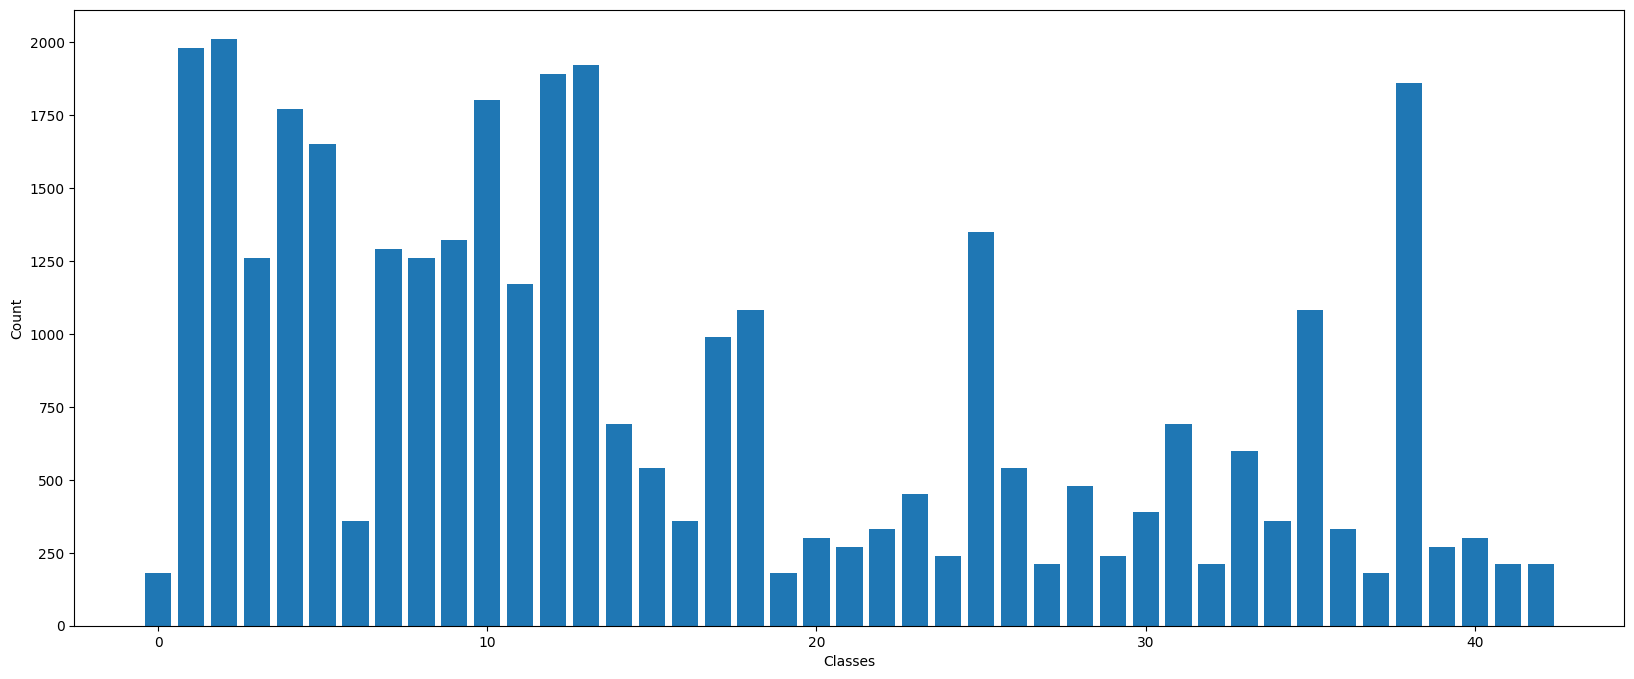

In [178]:
# Class count visualization train dataset
plt.figure(figsize=(20, 8))
plt.bar(unique_classes, class_counts)
plt.xlabel('Classes')
plt.ylabel('Count')
plt.show()

### Images extraction

In [179]:
output_dir = '../dataset/extracted_images'
os.makedirs(output_dir, exist_ok=True)

train_dir = os.path.join(output_dir, "train")
val_dir = os.path.join(output_dir, "validation")
test_dir = os.path.join(output_dir, "test")
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

images = train_images
labels = train_labels


def extract_images(image, label, base_dir):
    for index, (img_array, label) in enumerate(zip(image, label)):
        label_dir = os.path.join(base_dir, f"label_{label}")
        os.makedirs(label_dir, exist_ok=True)
        img = Image.fromarray(img_array)
        img.save(os.path.join(label_dir, f"image_{index}.png"))


extract_images(train_images, train_labels, train_dir)
extract_images(valid_images, valid_labels, val_dir)
extract_images(test_images, test_labels, test_dir)

print(f"Images saved in the directories: {train_dir}, {val_dir}, and {test_dir}")

Images saved in the directories: ../dataset/extracted_images/train, ../dataset/extracted_images/validation, and ../dataset/extracted_images/test


### CNN the model

In [193]:
# noinspection PyUnresolvedReferences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.src.optimizers import Adam


def make_model(learning_rate=0.0001, drop_rate=0.5):
    # Define the model
    model = Sequential()

    # Input Layer
    model.add(Input(shape=(32, 32, 3)))

    # Convolutional Layer 1 + ReLU
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
    # Pooling Layer 1
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Convolutional Layer 2 + ReLU
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    # Pooling Layer 2
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Convolutional Layer 3 + ReLU
    model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
    # Pooling Layer 3
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Flatten the output from convolutional layers to feed into Dense layers
    model.add(Flatten())

    # Fully Connected Layer (Dense)
    model.add(Dense(units=128, activation='relu'))

    # Dropout to prevent overfitting
    model.add(Dropout(drop_rate))

    # Fully Connected (Dense) Layer 2 (Output Layer, 43 classes in the dataset)
    model.add(Dense(units=43, activation='softmax'))

    optimizer = Adam(learning_rate=learning_rate)
    # Compile the model
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Create the data generator, load data

In [181]:
# noinspection PyUnresolvedReferences
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1. / 255,
                                   rotation_range=50,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

val_test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(32, 32),
                                                    batch_size=32,
                                                    shuffle=True,
                                                    class_mode='sparse')

val_generator = val_test_datagen.flow_from_directory(val_dir,
                                                     target_size=(32, 32),
                                                     batch_size=32,
                                                     class_mode='sparse',
                                                     shuffle=False)

test_generator = val_test_datagen.flow_from_directory(test_dir,
                                                      target_size=(32, 32),
                                                      batch_size=32,
                                                      class_mode='sparse',
                                                      shuffle=False)

Found 34799 images belonging to 43 classes.
Found 4410 images belonging to 43 classes.
Found 12630 images belonging to 43 classes.


### Train the model

In [182]:
# Train the model
def train_model(model, train, epochs, test):
    return model.fit(train, steps_per_epoch=train.batch_size, epochs=epochs, validation_data=test,
                     validation_steps=test.batch_size)

In [183]:
model = make_model()
# Summary
model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_27 (Conv2D)              │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 43)             │         5,547 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 164,459 (642.42 KB)

 Trainable params: 164,459 (642.42 KB)

 Non-trainable params: 0 (0.00 B)

In [184]:
history = train_model(model, train_generator, 250, test_generator)

Epoch 1/250


/Users/roman_didyk/Documents/dev/python/rd-ml-capstone1-2024/.venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.0316 - loss: 3.7448 - val_accuracy: 0.6475 - val_loss: 3.4564
Epoch 2/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.0601 - loss: 3.6896 - val_accuracy: 0.0000e+00 - val_loss: 3.1962
Epoch 3/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.0531 - loss: 3.6598 - val_accuracy: 0.0000e+00 - val_loss: 3.1773
Epoch 4/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.0630 - loss: 3.6392 - val_accuracy: 0.0000e+00 - val_loss: 3.1626
Epoch 5/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.0758 - loss: 3.5826 - val_accuracy: 0.0000e+00 - val_loss: 3.2138
Epoch 6/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.0426 - loss: 3.5928 - val_accuracy: 0.1758 - val_loss: 3.0566
Epoch 7/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.0725 - loss: 3.5562 - val_accuracy: 0.0000e+00 - val_loss: 3.1924
Epoch 8/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.0649 - loss: 3.5711 - val_accu

### Evaluate the model

In [185]:
train_loss, train_acc = model.evaluate(train_generator, steps=train_generator.batch_size)
print(f"Train accuracy: {train_acc * 100:.2f}%")
print(f"Train Loss: {train_loss:.2f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5471 - loss: 1.4717
Train accuracy: 55.57%
Train Loss: 1.44


In [186]:
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.batch_size)
print(f"Test accuracy: {test_acc * 100:.2f}%")
print(f"Test Loss: {train_loss:.2f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5456 - loss: 1.6331
Test accuracy: 68.95%
Test Loss: 1.44


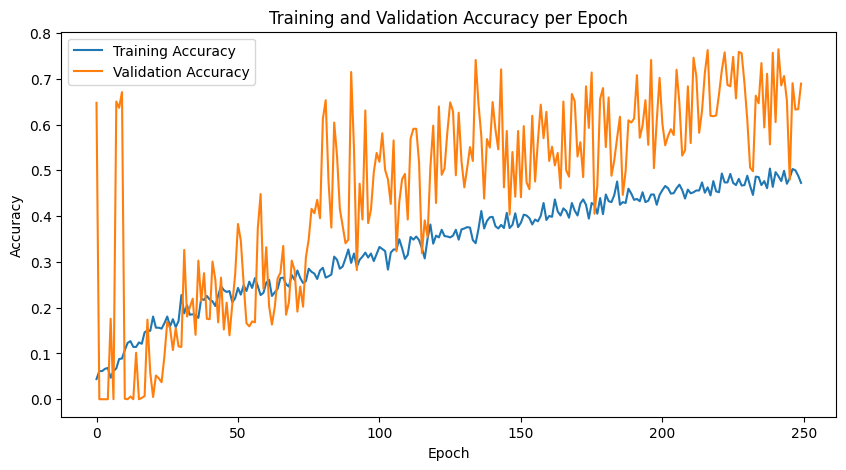

In [187]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.figure(figsize=(10, 5))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks()
plt.legend()
plt.show()

### Learning rate adjustment

In [188]:
lr_score = {}

for lr in [0.0001, 0.001, 0.01]:
    print(lr)
    model = make_model(learning_rate=lr)
    history = train_model(model, train_generator, 250, test_generator)
    lr_score[lr] = history.history
    print()

0.0001
Epoch 1/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.0481 - loss: 3.7356 - val_accuracy: 0.0000e+00 - val_loss: 3.5134
Epoch 2/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0509 - loss: 3.6915 - val_accuracy: 0.2217 - val_loss: 3.2710
Epoch 3/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0521 - loss: 3.6346 - val_accuracy: 0.7031 - val_loss: 2.9982
Epoch 4/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.0603 - loss: 3.6096 - val_accuracy: 0.7031 - val_loss: 3.0189
Epoch 5/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0484 - loss: 3.6385 - val_accuracy: 0.7031 - val_loss: 3.0637
Epoch 6/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0688 - loss: 3.6050 - val_accuracy: 0.6816 - val_loss: 3.0308
Epoch 7/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0673 - loss: 3.6135 - val_accuracy: 0.3535 - val_loss: 3.0457
Epoch 8/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0683 - loss: 3.5581 - val_a

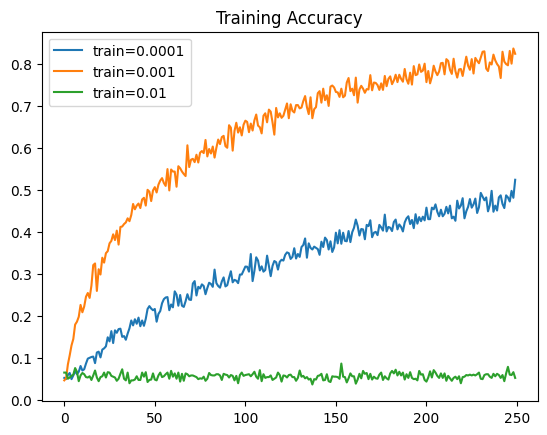

In [190]:
for lr, hist in lr_score.items():
    plt.plot(hist['accuracy'], label=('train=%s' % lr))

plt.title('Training Accuracy with Learning rate adjustment')
plt.xticks()
plt.legend()

### Drop rate adjustment

In [194]:
learning_rate = 0.001
dr_score = {}

for dr in [0.0, 0.2, 0.5, 0.8]:
    print(dr)
    model = make_model(learning_rate=learning_rate, drop_rate=dr)
    history = train_model(model, train_generator, 250, test_generator)
    dr_score[dr] = history.history
    print()
    print()

0.0
Epoch 1/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.0361 - loss: 3.6841 - val_accuracy: 0.0000e+00 - val_loss: 3.1574
Epoch 2/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.0699 - loss: 3.5179 - val_accuracy: 0.5928 - val_loss: 2.9051
Epoch 3/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.1133 - loss: 3.4281 - val_accuracy: 0.6152 - val_loss: 2.6121
Epoch 4/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.0936 - loss: 3.2989 - val_accuracy: 0.1104 - val_loss: 2.7213
Epoch 5/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.1624 - loss: 3.1028 - val_accuracy: 0.4668 - val_loss: 2.4328
Epoch 6/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.1836 - loss: 3.0086 - val_accuracy: 0.0039 - val_loss: 2.6652
Epoch 7/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.1899 - loss: 2.8369 - val_accuracy: 0.1904 - val_loss: 2.4935
Epoch 8/250
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.2115 - loss: 2.6655 - val_accu

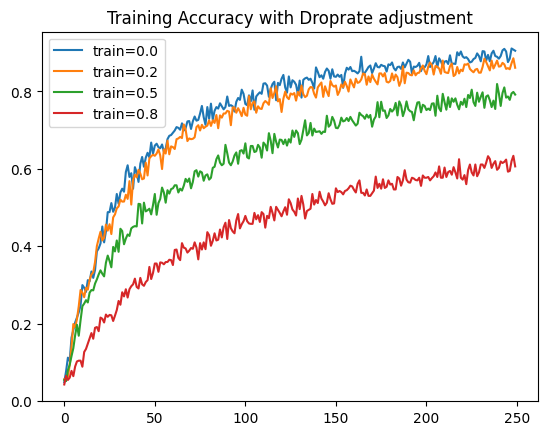

In [197]:
for dr, hist in dr_score.items():
    plt.plot(hist['accuracy'], label=('train=%s' % dr))

plt.title('Training Accuracy with Droprate adjustment')
plt.xticks()
plt.legend()

In [201]:
learning_rate = 0.001
size = 400
droprate = 0.0

model = make_model(learning_rate=learning_rate, drop_rate=dr)
history = train_model(model, train_generator, size, test_generator)

Epoch 1/400
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.0285 - loss: 3.7651 - val_accuracy: 0.0000e+00 - val_loss: 3.6337
Epoch 2/400
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.0491 - loss: 3.7042 - val_accuracy: 0.0000e+00 - val_loss: 3.4877
Epoch 3/400
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.0606 - loss: 3.6465 - val_accuracy: 0.0000e+00 - val_loss: 3.3438
Epoch 4/400
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.0548 - loss: 3.6489 - val_accuracy: 0.0000e+00 - val_loss: 3.3399
Epoch 5/400
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0662 - loss: 3.5695 - val_accuracy: 0.0000e+00 - val_loss: 3.1614
Epoch 6/400
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0734 - loss: 3.5758 - val_accuracy: 0.0947 - val_loss: 3.2074
Epoch 7/400
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0679 - loss: 3.4582 - val_accuracy: 0.0000e+00 - val_loss: 3.0466
Epoch 8/400
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0745 - loss: 3

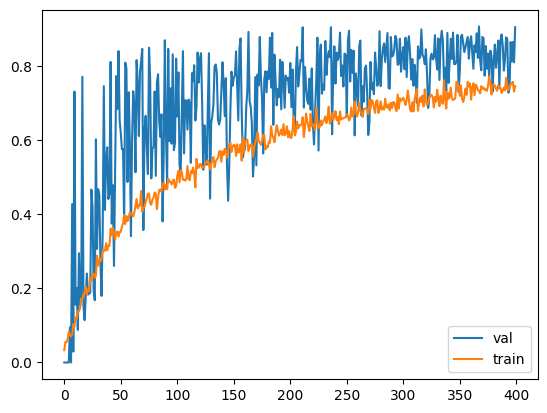

In [202]:
plt.plot(history.history['val_accuracy'], label='val')
plt.plot(history.history['accuracy'], label='train')

plt.legend()